# Methodology VCT

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored

import paper

In [3]:
ship_name = "optiwise"
model = catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL")['simple']()

[12/03/24 19:46:43] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=962476;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=918633;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=75116;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=368602;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'optiwise.models_VCT_polynomial_rudder_MDL'      ]8;id=504858;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=571605;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [4]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
#df_VCT = model.prime(data=df_VCT)
mask = df_VCT['test type'] == 'Rudder angle resistance (no propeller)'
df_VCT = df_VCT.loc[~mask].copy()

df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

                    INFO     Loading data from 'optiwise.df_VCT_scaled' (CSVDataSet)...         ]8;id=509014;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=466700;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [5]:
meta_data_all = catalog.load(f"{ship_name}.time_series_meta_data")
ids = [
    23590,
    23591,
    23594,
    23596,
]

meta_datas = meta_data_all.loc[ids].copy()


                    INFO     Loading data from 'optiwise.time_series_meta_data' (CSVDataSet)... ]8;id=701347;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=86947;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [6]:

dataframes = {}
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    #df_EKF_smooth['thrust'] = df_EKF_smooth['thrust_port'] + df_EKF_smooth['thrust_stbd']

    #df_EKF_smooth = model.prime(df_EKF_smooth)
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    dataframes[name] = df_EKF_smooth

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=905452;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=320530;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=655058;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=590951;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=343489;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=431107;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=389705;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=809323;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=931469;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=417173;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [7]:
#df_VCT_mirrored = add_mirrored(df_VCT)
#df_VCT_mirrored['beta_deg'] = np.rad2deg(df_VCT_mirrored['beta'])

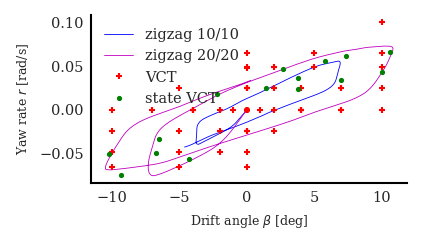

In [20]:
fig,ax=plt.subplots()

colors = ['b','m']
for name,data in dataframes.items():

    data['beta_deg'] = np.rad2deg(data['beta'])
    data.plot(x='beta_deg',y='r', color=colors.pop(0), ax=ax, label=name)

mask = df_VCT['name'].str.contains('state_')
df_VCT.loc[~mask].plot(x='beta_deg', y='r', style='r+', label='VCT', ax=ax)
df_VCT.loc[mask].plot(x='beta_deg', y='r', style='g.', label='state VCT', ax=ax)

ax.set_xlabel(r'Drift angle $\beta$ [deg]')
#ax.set_ylabel(r"Yaw rate $r'$ [-]")
ax.set_ylabel(r"Yaw rate $r$ [rad/s]")

ax.legend(loc='upper left')
fig.set_size_inches(paper.figure_width/2,paper.figure_height/2)
paper.save_fig(fig,"phase_plot.svg")

In [9]:
df_VCT['test type'].unique()


array(['Circle', 'Circle + Drift', 'Circle + Drift + rudder angle',
       'Circle + rudder angle', 'Drift angle', 'Rudder and drift angle',
       'Rudder angle', 'Thrust variation', 'self propulsion'],
      dtype=object)

In [10]:
df_VCT[['test type','V','beta_deg','r','delta','rev']]

,test type,V,beta_deg,r,delta,rev
0,Circle,0.935783,-0.00000,0.065215,0.000000,10.322627
1,Circle,0.935783,-0.00000,0.048911,0.000000,10.322627
2,Circle,0.935783,-0.00000,0.024456,0.000000,10.322627
3,Circle,0.935783,0.00000,-0.065215,-0.000000,10.322627
4,Circle,0.935783,0.00000,-0.048911,-0.000000,10.322627
5,Circle,0.935783,0.00000,-0.024456,-0.000000,10.322627
6,Circle + Drift,0.935783,2.00000,0.048911,0.000000,10.322627
8,Circle + Drift,0.935783,-10.00000,-0.065215,-0.000000,10.322627
10,Circle + Drift,0.935783,-5.00000,-0.065215,-0.000000,10.322627
11,Circle + Drift,0.935783,-10.00000,-0.048911,-0.000000,10.322627


In [11]:
keys=['V','beta_deg','r','delta_deg','rev']
df_VCT['delta_deg'] = np.rad2deg(df_VCT['delta'])

In [12]:
df_VCT.groupby(by='test type').get_group('Thrust variation')['rev']


68     5.828881
69     6.423121
70     7.631802
71     5.828881
72     6.423121
73     7.631802
74     8.636526
75     9.516984
76    11.307879
77     8.636526
78     9.516984
79    11.307879
Name: rev, dtype: float64

In [13]:
df_mins = df_VCT.groupby(by='test type').min()[keys]
df_maxs = df_VCT.groupby(by='test type').max()[keys]
df_first = df_VCT.groupby(by='test type').first()[keys]

In [14]:
min = df_mins.iloc[0]
max = df_maxs.iloc[0]
mask = min!=max
min[mask].index

Index(['r'], dtype='object')

In [15]:
_ = []
key_decimals={
    'beta_deg':0,
    'delta_deg':0,
    'rev':1
}
for index, min in df_mins.iterrows():
    max = df_maxs.loc[index]
    mask = min!=max
    
    
    #s = pd.Series(name=index)
    s = df_first.loc[index].apply(lambda x: f"{x:0.2f}" if x > 0 else "")
    for key in min[mask].index:
        decimals = key_decimals.get(key,2)
        s[key] = f"{min[key]:0.{decimals}f} -- {max[key]:0.{decimals}f}"

    _.append(s)
    

In [16]:
df_variations = pd.DataFrame(_)
df_variations.index.name='Test type'

In [17]:
df_variations

,V,beta_deg,r,delta_deg,rev
Test type,,,,,
Circle,0.94,,-0.07 -- 0.07,,10.32
Circle + Drift,0.94,-10 -- 10,-0.07 -- 0.10,,10.32
Circle + Drift + rudder angle,0.64 -- 0.94,-10 -- 11,-0.08 -- 0.07,-20 -- 20,7.1 -- 10.4
Circle + rudder angle,0.94,,-0.02 -- 0.05,-4 -- 10,10.32
Drift angle,0.94,-10 -- 10,,,10.3 -- 10.5
Rudder and drift angle,0.94,-4 -- 7,,-4 -- 10,10.32
Rudder angle,0.62 -- 0.94,,,-15 -- 15,7.0 -- 10.4
Thrust variation,0.62 -- 0.94,,,-10 -- 10,5.8 -- 11.3
self propulsion,0.62 -- 0.94,,,,7.0 -- 10.3


In [18]:
df_variations.to_csv(paper.file_path_with_nb_ref("variations.csv", directory='tables'), index=True)